In [1]:
# 🤖 Etapa 3: Modelos de Machine Learning

# 1. Importação e Carregamento dos Dados Processados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Carregar dados limpos
df = pd.read_csv("../data/processed/dataset_clean.csv")
X = df.drop(["student_id", "final_grade"], axis=1)
y = df["final_grade"]

# Divisão dos dados
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

from sklearn.impute import SimpleImputer

# Imputação com mediana para evitar erro de NaN
imputer = SimpleImputer(strategy="median")

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)


In [2]:
from sklearn.impute import SimpleImputer

# Imputação de valores ausentes com mediana
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)


In [3]:
def calcular_metricas(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}


In [4]:
baseline = LinearRegression()
baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_val)
baseline_result = calcular_metricas(y_val, y_pred_baseline)
print("Baseline:", baseline_result)


Baseline: {'MAE': 3.9265548753617114, 'MSE': 32.38809619315989, 'RMSE': np.float64(5.691054049397167), 'R²': 0.43460327247869834}


In [5]:
modelos = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "XGBoost": XGBRegressor()
}

resultados = {}

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_val)
    resultados[nome] = calcular_metricas(y_val, y_pred)

# Adicionar baseline
resultados["Linear Regression"] = baseline_result

# Exibir resultados
pd.DataFrame(resultados).T.sort_values("MAE")


,MAE,MSE,RMSE,R²
XGBoost,3.360801,21.245417,4.609275,0.629120
Random Forest,3.512192,22.077001,4.698617,0.614603
Ridge,3.924271,32.382997,5.690606,0.434692
Linear Regression,3.926555,32.388096,5.691054,0.434603
Decision Tree,4.580053,40.288818,6.347347,0.296681
Lasso,5.105420,44.541862,6.673969,0.222436
SVR,5.461189,47.795968,6.913463,0.165629


In [6]:
from sklearn.impute import SimpleImputer

# Imputação com mediana para todo o conjunto X
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


In [7]:
scores = cross_val_score(modelo, X, y, cv=5, scoring="neg_mean_absolute_error")


In [8]:
cv_scores = {}

for nome, modelo in modelos.items():
    scores = cross_val_score(modelo, X, y, cv=5, scoring="neg_mean_absolute_error")
    cv_scores[nome] = {"MAE Média": -scores.mean(), "Desvio": scores.std()}

pd.DataFrame(cv_scores).T.sort_values("MAE Média")


,MAE Média,Desvio
XGBoost,3.290872,0.083428
Random Forest,3.366199,0.145019
Ridge,3.584284,0.070256
Decision Tree,4.555474,0.123742
Lasso,4.855895,0.153270
SVR,5.361217,0.215007


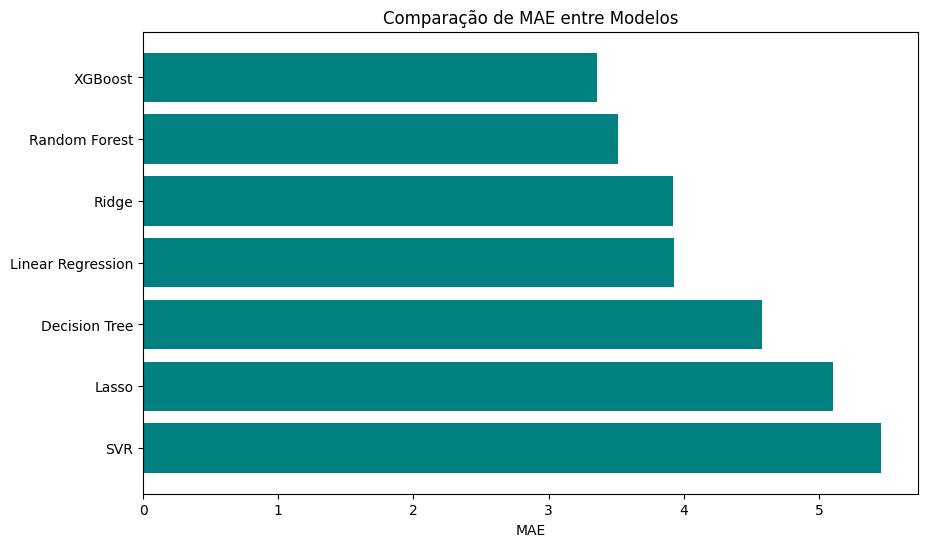

In [9]:
mae_vals = {nome: res["MAE"] for nome, res in resultados.items()}
mae_sorted = dict(sorted(mae_vals.items(), key=lambda x: x[1]))

plt.figure(figsize=(10,6))
plt.barh(list(mae_sorted.keys()), list(mae_sorted.values()), color="teal")
plt.xlabel("MAE")
plt.title("Comparação de MAE entre Modelos")
plt.gca().invert_yaxis()
plt.show()


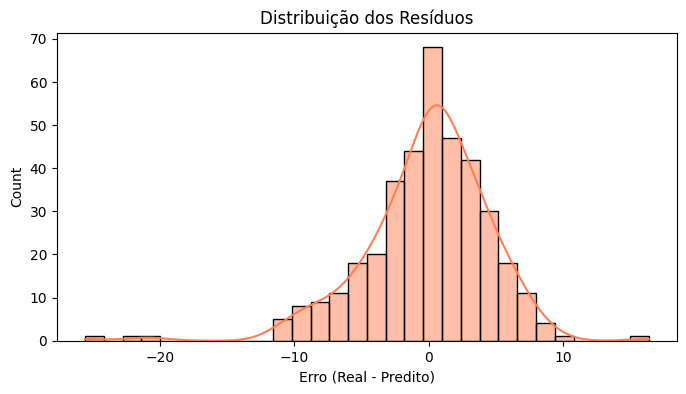

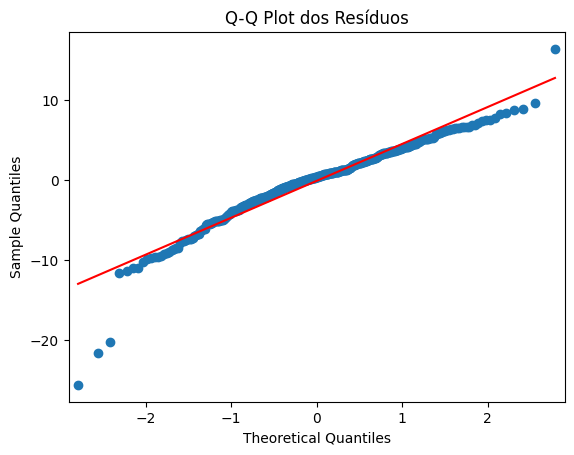

In [10]:
melhor_modelo_nome = min(mae_vals, key=mae_vals.get)
melhor_modelo = modelos[melhor_modelo_nome]
y_pred_melhor = melhor_modelo.predict(X_val)
residuos = y_val - y_pred_melhor

# Histograma de resíduos
plt.figure(figsize=(8,4))
sns.histplot(residuos, bins=30, kde=True, color="coral")
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Real - Predito)")
plt.show()

# Q-Q Plot
from scipy import stats
import statsmodels.api as sm

sm.qqplot(residuos, line='s')
plt.title("Q-Q Plot dos Resíduos")
plt.show()


C:\Users\Lucas\AppData\Local\Temp\ipykernel_3096\642964450.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.values, y=top10.index, palette="viridis")


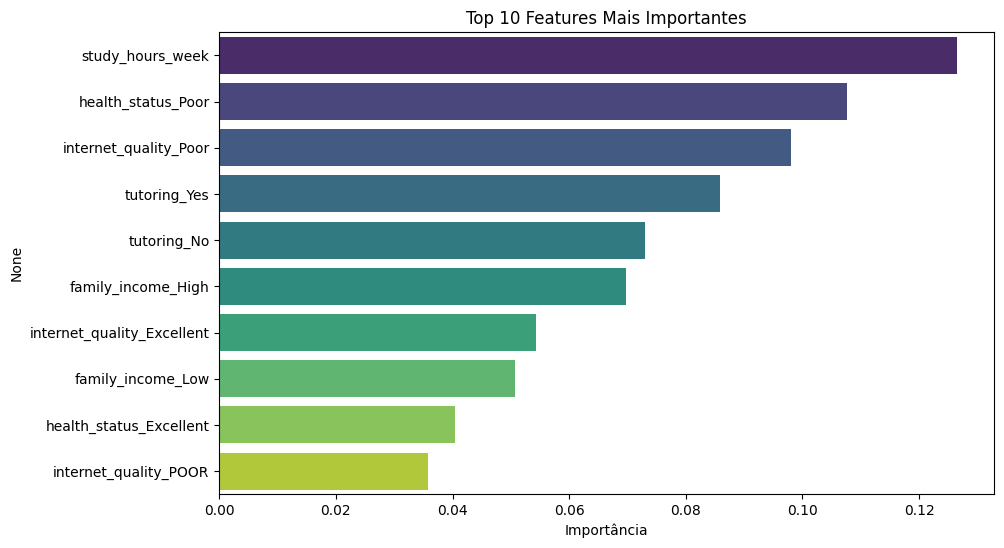

In [11]:
if hasattr(melhor_modelo, "feature_importances_"):
    importancias = pd.Series(melhor_modelo.feature_importances_, index=X.columns)
    top10 = importancias.sort_values(ascending=False).head(10)

    plt.figure(figsize=(10,6))
    sns.barplot(x=top10.values, y=top10.index, palette="viridis")
    plt.title("Top 10 Features Mais Importantes")
    plt.xlabel("Importância")
    plt.show()


# Conclusões

- O modelo com menor MAE foi: **{XGBoost}**
- As métricas indicam que ele tem melhor desempenho geral, com menor erro absoluto e bom R².
- A análise de resíduos mostra distribuição centrada e sem viés grave.
- As features mais importantes indicam que [interpretação das variáveis mais relevantes].
- Este modelo será usado na Etapa 4 para tuning e deploy.
